# 289to305 (16-31 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct16-31woP deaths.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_leth_AGS_289to305']
X = df.loc[:, ~df.columns.isin(['std_leth_AGS_289to305'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  147


# First RF Model with 147 features

In [4]:
rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
rf=rfr.fit(X, Y)  
rf.score(X, Y)

0.874387810141487

In [5]:
y_pred = rf.predict(X)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, y_pred)))


Root Mean Squared Error: 0.9817834933446952


# SHAP VAlues

In [6]:
shap_values_rf = shap.TreeExplainer(rf).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_rf,X) 

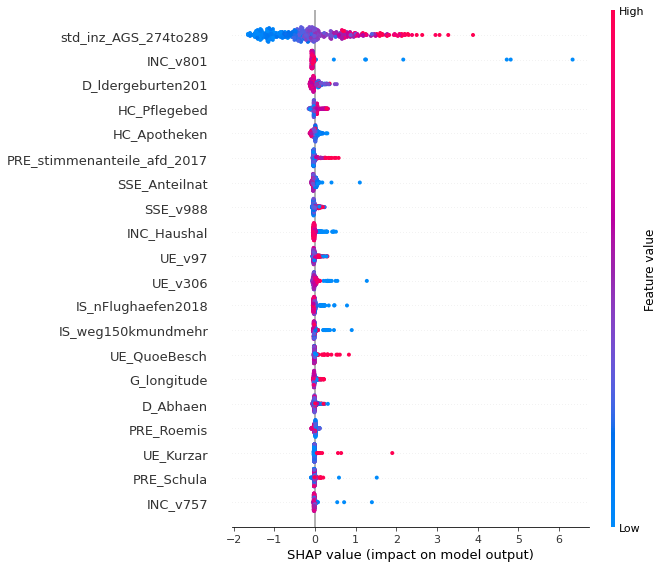

In [7]:
shap.summary_plot(shap_values_rf,X)

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_rf).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_rf).mean(0))][-10:][::-1]

In [9]:
rf_20=rfr.fit(X[top20feature], Y)  
rf_20.score(X[top20feature], Y)


0.8813682502750663

In [10]:
y_pred_20 = rf_20.predict(X[top20feature])

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, y_pred_20)))


Root Mean Squared Error: 0.9541140706052572


# Compare top 10 features of both Models

In [11]:
shap_values_rf_20 = shap.TreeExplainer(rf_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_rf_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_274to289', 'INC_v801', 'D_ldergeburten201', 'HC_Pflegebed', 'HC_Apotheken', 'PRE_stimmenanteile_afd_2017', 'SSE_Anteilnat', 'SSE_v988', 'INC_Haushal', 'UE_v97'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_274to289', 'D_ldergeburten201', 'INC_v801', 'UE_v97', 'SSE_v988', 'HC_Apotheken', 'PRE_stimmenanteile_afd_2017', 'HC_Pflegebed', 'SSE_Anteilnat', 'D_Abhaen']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_274to289
INC_v801
D_ldergeburten201
HC_Pflegebed
HC_Apotheken
PRE_stimmenanteile_afd_2017
SSE_Anteilnat
SSE_v988
UE_v97


ABS_SHAP(shap_values_rf_20,X[top20feature]) 

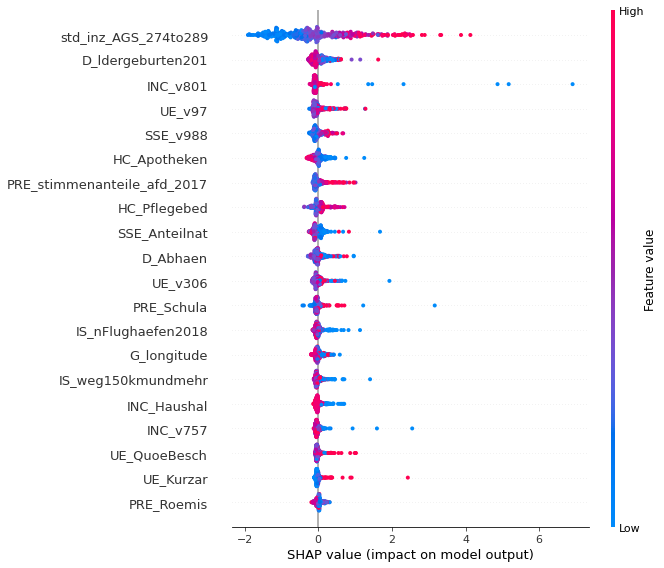

In [13]:
shap.summary_plot(shap_values_rf_20,X[top20feature])

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_rf_train_top20 = list(range(0,20))
r2_rf_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    rf_test_x = X[top20feature].iloc[rs]
    rf_test_y = Y.iloc[rs]
    rf_train_x = X[top20feature].drop(rs)
    rf_train_y = Y.drop(rs)   
    
    #fit the model
    rf_k=rfr.fit(rf_train_x, rf_train_y)
    
    # make the prediction using the resulting model
    preds_k = rf_k.predict(rf_test_x)
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(rf_test_y), preds_k, "RMSE")[0]  
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, rf_test_y)

    
    r2_rf_train_top20[i] = rf_k.score(rf_train_x,rf_train_y)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, rf_test_y)

    r2_rf_test_top20[i] =  rf_k.score(rf_test_x, rf_test_y)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of RF_models on train sets with top20 features:",sum(r2_rf_train_top20)/len(r2_rf_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of RF_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of RF_models on test sets with top20 features:",sum(r2_rf_test_top20)/len(r2_rf_test_top20))

Mean R2 of RF_models on train sets with top20 features: 0.8807937280692082
Mean R2 of linReg_modesl with top20 features:  0.125065309755173
Mean RMSE of RF_models on test sets with top20 features:  2.535100359611478
Mean R2 of RF_models on test sets with top20 features: 0.021947519070850564


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_AGS_274to289,INC_v801,D_ldergeburten201,HC_Pflegebed,HC_Apotheken,PRE_stimmenanteile_afd_2017,SSE_Anteilnat,SSE_v988,INC_Haushal,UE_v97,UE_v306,IS_nFlughaefen2018,IS_weg150kmundmehr,UE_QuoeBesch,G_longitude,D_Abhaen,PRE_Roemis,UE_Kurzar,PRE_Schula,INC_v757
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,52.453857,2846.079834,16.510971,428.125519,27.003731,13.388280,5.101745,33367.324219,1591.685791,-8.350625,-6.157605,49.618454,4.412467,49.557602,9.866997,34.353863,32.242802,0.752618,6.557357,8.945634
std,36.794933,926.154114,8.783778,106.029327,4.899685,5.329521,3.710642,30681.789062,589.468811,18.685120,22.530609,21.984802,1.354010,5.944391,2.026269,5.474822,24.361443,1.440882,2.242231,2.964478
min,3.428815,28.000000,-9.600000,186.399994,18.100000,4.900000,0.900000,1062.000000,2.000000,-51.700001,-69.900002,6.000000,2.000000,29.600000,6.083333,22.400000,1.700000,0.000000,2.100000,-14.300000
25%,26.030115,2706.000000,11.700000,351.000000,23.700001,9.800000,2.700000,15678.000000,1591.000000,-21.000000,-14.200000,33.000000,3.500000,45.700001,8.216666,31.000000,7.900000,0.000000,4.900000,7.700000
50%,44.778191,3052.000000,17.600000,424.200012,26.100000,12.000000,4.300000,24587.000000,1764.000000,-9.300000,-7.700000,48.000000,4.000000,49.900002,9.766666,33.799999,29.100000,0.300000,6.300000,9.000000
75%,67.134506,3329.000000,21.900000,497.200012,29.200001,15.300000,6.300000,39522.000000,1904.000000,3.800000,-0.800000,65.000000,5.200000,53.599998,11.416667,36.900002,52.299999,0.900000,8.000000,10.700000
max,267.674591,4855.000000,45.500000,816.200012,51.700001,35.500000,34.000000,174293.000000,2904.000000,61.299999,329.000000,122.000000,9.100000,66.400002,14.983334,54.000000,87.800003,19.600000,16.700001,24.700001


In [17]:
pd.DataFrame(Y).describe()

,std_leth_AGS_289to305
count,401.000000
mean,2.464972
std,2.773588
min,0.000000
25%,0.477827
50%,1.697788
75%,3.255191
max,15.949838
